In [7]:
from PaceSimulator import PaceSimulator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

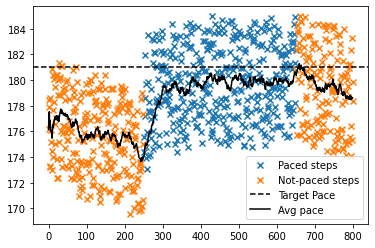

In [39]:
simulator_ = PaceSimulator()
pace = []
pacing = []
for i in range(250):
    value = 0
    pace.append(simulator_.predict(value, 181, 181))
    pacing.append(value)
for i in range(400):
    value = 1
    pace.append(simulator_.predict(value, 181, 181))
    pacing.append(value)
for i in range(150):
    value = 0
    pace.append(simulator_.predict(value, 181, 181))
    pacing.append(value)


plt.figure()
x = np.linspace(0, len(pace), len(pace))

plt.scatter(x[np.array(pacing)==1], np.array(pace)[np.array(pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(pacing)==0], np.array(pace)[np.array(pacing)==0], marker="x", label='Not-paced steps')

plt.axhline(y=181, color='k', linestyle='--', label='Target Pace')

m_a = pd.DataFrame(pace, columns = ['Pace']).ewm(alpha=0.05).mean()
plt.plot(m_a, color="k", label='Avg pace')

plt.legend()
plt.show()

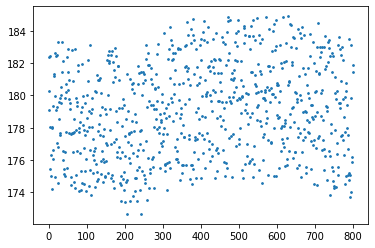

In [9]:

## Generate some noisy data
n = len(pace) # Length of the data

data = np.array(pace)

plt.scatter(x, data, s=3)

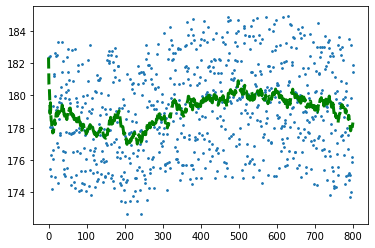

In [10]:
rho = 0.95 # Rho value for smoothing

s_prev = 0 # Initial value ewma value

# Empty arrays to hold the smoothed data
ewma, ewma_bias_corr = np.empty(0), np.empty(0)

for i,y in enumerate(data):

    # Variables to store smoothed data point
    s_cur = 0
    s_cur_bc = 0

    #############################################################################
    #                   TODO: Implement EWMA update as s_cur                    #
    #                 and EWMA with bias correction as s_cur_bc                 #
    #############################################################################

    s_cur = rho * s_prev + (1-rho) * y
    s_cur_bc = (s_cur)/(1-math.pow(rho,i+1))

    #############################################################################
    #                            END OF YOUR CODE                               #
    #############################################################################

    # Append new smoothed value to array
    ewma = np.append(ewma,s_cur)
    ewma_bias_corr = np.append(ewma_bias_corr,s_cur_bc)

    s_prev = s_cur

plt.scatter(x, data, s=3) # Plot the noisy data in gray
# plt.plot(x, ewma, 'r--', linewidth=3) # Plot the EWMA in red
plt.plot(x, ewma_bias_corr, 'g--', linewidth=3) # Plot the EWMA with bias correction in green

In [11]:
class EwmaBiasState:
    def __init__(self, rho=0.95):
        self.rho = rho # Rho value for smoothing
        self.s_prev = 0 # Initial value ewma value
        self.timestep = 0
        self.s_cur = 0
        self.s_cur_bc = 0

    def get_next_state (self, input):
        self.s_cur = self.rho * self.s_prev + (1-self.rho) * input
        self.s_cur_bc = (self.s_cur)/(1-math.pow(self.rho,self.timestep+1))
        self.s_prev = self.s_cur
        self.timestep = self.timestep + 1

        return self.s_cur_bc

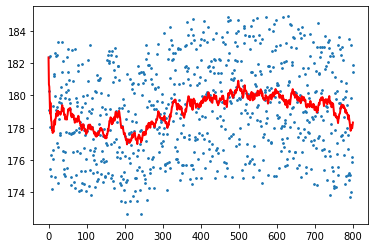

In [12]:
moving_average = EwmaBiasState()
ewma = np.empty(0)

for y in data:
    ewma = np.append(ewma, moving_average.get_next_state(y))

plt.scatter(x, data, s=3)
plt.plot(x, ewma, 'r-', linewidth=2)

In [72]:
class Timer:
    def __init__(self, time_limit=30):
        self.time_step = 0
        self.active = 0
        self.time_limit = time_limit

    def tick(self):
        self.time_step = self.time_step + 1
        if self.time_step == self.time_limit:
            self.time_step = 0

    def timer_on(self):
        if self.time_step == 0:
            return 0
        else:
            return 1

In [78]:
class RunningEnv:
    # Beeps should be active for 30 timesteps (10 sec)
    def __init__(self, pref_pace, time_limit=30):
        self.state = EwmaBiasState()
        self.simulator = PaceSimulator()
        self.pace_active = 0
        self.pref_pace = pref_pace
        self.time_limit = time_limit
        self.current_timer = Timer(self.time_limit)

    def step(self, action, target_pace):
        if action == 1:
            self.current_timer = Timer(self.time_limit)
            self.current_timer.tick()
            self.pace_active = 1
            pacing_value = 1
        else:
            self.pace_active = 0
            pacing_value = 0
            if self.current_timer.timer_on():
                self.current_timer.tick()
                pacing_value = 1

        current_pace = self.simulator.predict(pacing_value, self.pref_pace, target_pace)
        new_state = self.state.get_next_state(current_pace)

        reward = self.get_distance_reward(target_pace, current_pace) + self.get_pacing_reward()

        return current_pace, new_state, reward, pacing_value

    def get_distance_reward(self, target_pace, current_pace):
        return -abs(target_pace - current_pace) + 1

    def get_pacing_reward(self):
        if self.current_timer.timer_on():
            return -1
        else:
            return 0

-5.355972057350777


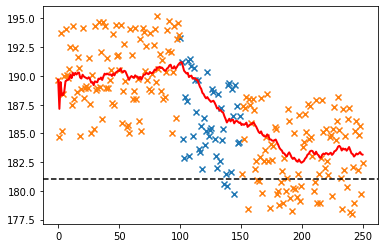

In [79]:
env = RunningEnv(181)
state = np.empty(0)
pace = np.empty(0)
rewards = np.empty(0)
env_pacing = np.empty(0)
pacing = []

for y in range(100):
    value = 0
    current_pace, new_state, reward, real_pacing = env.step(value, 181)
    state = np.append(state, new_state)
    pace = np.append(pace, current_pace)
    rewards = np.append(rewards, reward)
    env_pacing = np.append(env_pacing, real_pacing)
    pacing.append(value)

for y in range(50):
    value = 1
    current_pace, new_state, reward, real_pacing = env.step(value, 181)
    state = np.append(state, new_state)
    pace = np.append(pace, current_pace)
    rewards = np.append(rewards, reward)
    env_pacing = np.append(env_pacing, real_pacing)
    pacing.append(value)

for y in range(100):
    value = 0
    current_pace, new_state, reward, real_pacing = env.step(value, 181)
    state = np.append(state, new_state)
    pace = np.append(pace, current_pace)
    rewards = np.append(rewards, reward)
    env_pacing = np.append(env_pacing, real_pacing)
    pacing.append(value)
# for y in range(100):
#     current_pace, new_state, reward = env.step(0, 181)
#     state = np.append(state, new_state)
#     pace = np.append(pace, current_pace)
#     rewards = np.append(rewards, reward)

x = np.linspace(0, len(pacing), len(pacing))
plt.scatter(x[np.array(pacing)==1], np.array(pace)[np.array(pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(pacing)==0], np.array(pace)[np.array(pacing)==0], marker="x", label='Not-paced steps')

plt.axhline(y=181, color='k', linestyle='--', label='Target Pace')

plt.plot(x, state, 'r-', linewidth=2)

print(rewards.mean())

In [82]:
pacing[np.array(pacing)==1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,